In [34]:
import numpy as np
from numpy import linalg as LA
from qiskit.visualization import circuit_drawer, plot_histogram, plot_state_qsphere
import qiskit
from qiskit.quantum_info import Statevector, DensityMatrix, entropy
from qiskit.visualization import plot_circuit_layout
import pandas as pd
from matplotlib.pyplot import figure
from qiskit import QuantumRegister, QuantumCircuit, ClassicalRegister, Aer, assemble
from qiskit.providers.aer import noise
from qiskit.providers.aer.noise import NoiseModel
from qiskit.compiler import transpile
from qiskit.providers.aer import AerSimulator
from qiskit import IBMQ
import pylatexenc
from datetime import datetime
import numpy as np
import cmath
import numpy.linalg as LA
from scipy.sparse import diags
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from qiskit.algorithms import VQE
from qiskit.opflow import X, Z, I, Y
from qiskit.circuit import Parameter
from qiskit.aqua.components.optimizers import ADAM
from qiskit.aqua.operators import AerPauliExpectation
import numpy as np
import cmath
import numpy.linalg as LA
from scipy.sparse import diags
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import scipy.integrate as integrate
import scipy.special as special
import math
import numpy.linalg as LA 
pi=np.pi

In [35]:
IBMQ.save_account('4155b71f22eb3c7c385dcceb3b445f95a6f7b517d67336eac6b6bdce842c869e3fca7a5bca1d97a2331e689d3af55083ebc25b8451a028e28901936b3c5ea527',overwrite=True)
#IBMQ.enable_account('32750a5c86c5d6e48d1a486535e773be5b95e724042a89b101a0254afd4c4660f3a0873dd9e8f7026d8b4a85527828eb0ea113ce94a282304ade64563bb2d1e4')
IBMQ.load_account()
provider = IBMQ.get_provider()
IBMQC=provider.get_backend('ibmq_bogota')
noise_model = NoiseModel.from_backend(IBMQC)
sim = Aer.get_backend('qasm_simulator')
vec = Aer.get_backend('statevector_simulator')
backend = AerSimulator.from_backend(IBMQC)

ibmqfactory.load_account:WARNING:2022-05-02 22:06:58,433: Credentials are already in use. The existing account in the session will be replaced.


In [36]:
state =AerSimulator(method='statevector',
                        noise_model=noise_model)

In [37]:
def chi(V,E,omega):
  return (V/E)*(omega-1)

def Vp(E,omega,chi):
  return (chi*E)/(omega-1)

def sig(omega):
  return np.exp(-1j*np.pi*(omega/2))

###############Quasi Spin####################
def eigen(A):
    eigenValues, eigenVectors = LA.eig(A)
    idx = np.argsort(eigenValues)
    eigenValues = eigenValues[idx]
    eigenVectors = eigenVectors[:,idx]
    return (eigenValues, eigenVectors) 

def one_body(E,N):
  k = N/2
  m = np.arange(-k,k+1,1)
  return E*np.diag(m)

def two_body(V,N):
  k = N/2
  m = np.arange(-k,k+1,1)
  left =np.zeros(len(m)-2,dtype=complex)
  right = np.zeros(len(m)-2,dtype=complex)
  diag = np.zeros(len(m),dtype=complex)
  for i in range(len(left)):
    CG = cmath.sqrt(k*(k+1)-(m[i]+2)*(m[i]+1))*cmath.sqrt(k*(k+1)-m[i]*(m[i]+1))
    left[i] = CG
    right[i] = CG
  k = [left,diag,right]
  offset = [-2,0,2]
  return -0.5*V*diags(k,offset).toarray()

def quasi_spin(E,V,N):
  ob = one_body(E,N)
  tb = two_body(V,N)
  H = ob+tb 
  e,v = eigen(H)
  return e,H

############Hartee Fock##############
def E_HF(x,E,omega):
  if x < 1:
    EHF = -(omega/2)*E
  elif x >= 1:
    EHF = -(omega/4)*E*(x+(1/x))
  return EHF

############PAV###############
def PAV(x,E,omega,state):
  if x < 1:
    cos = 1
    H= 1
    EN = 1
  elif x >= 1:
    cos = 1/x
    t2 =(x/2)*(x**2-1)
    t1=1/x
    H = (t1**omega)*((1/t1)+(x/2)*(x**2-1))
    EN = (1/2)*(x+(1/x))
  if state == 'ground': 
    bot = 1+(sig(omega)**2)*(cos**omega)
    top = (-omega*E/2)*(EN+(sig(omega)**2)*H)
  elif state == 'excited':
    bot = 1-(sig(omega)**2)*(cos**omega)
    top = (-omega*E/2)*(EN-(sig(omega)**2)*H)
  return top/bot

#############VAP#############
#Ground State
def VAPG(t):
  a = (1-abs(t)**2)/(1+abs(t)**2)
  H = (-omega*E/2)*(a**omega)*((1/a)+(2*x*t**2)/(1-abs(t)**2)**2)
  EN = (omega*E/2)*((abs(t)**2-1)/(abs(t)**2+1)-((2*x*t**2)/(abs(t)**2+1)**2))

  cos = -(abs(t)**2-1)/(abs(t)**2+1)
  bot = 1+sig(omega)**2*cos**omega
  top = EN+(sig(omega)**2)*H
  return (top/bot).real

#Excited State
def VAPE(t):
  a = (1-abs(t)**2)/(1+abs(t)**2)
  H = (-omega*E/2)*(a**omega)*((1/a)+(2*x*t**2)/(1-abs(t)**2)**2)
  EN = (omega*E/2)*((abs(t)**2-1)/(abs(t)**2+1)-((2*x*t**2)/(abs(t)**2+1)**2))

  cos = -(abs(t)**2-1)/(abs(t)**2+1)
  bot = 1-sig(omega)**2*cos**omega
  top = EN-(sig(omega)**2)*H
  return (top/bot).real

### GCM#######################
def fac(k,omega):
  n = k+omega/2
  o = omega
  return math.factorial(o)/(math.factorial(n)*math.factorial(o-n))

def N(t1,t2,omega):
  k = np.arange(-omega/2,omega/2+1,1)
  L = []
  for i in k:
    nn = (1/2**omega)*np.exp(-1j*i*t1)*fac(i,omega)*np.exp(1j*i*t2)
    L.append(nn)
  return sum(L)

def nk(k,omega):
  return ((2*pi)/(2**omega))*fac(k,omega)

def Ham2(t1,t2,chi,omega):
  A1 = np.cos((t1+t2)/2)/np.cos((t1-t2)/2)
  a2 = (1+np.sin((t1+t2)/2)**2)/np.cos((t1-t2)/2)**2
  A2 = a2-1
  H = -(omega/2)*N(t1,t2,omega)*(A1+(chi/2)*A2)
  return H

def integral(t1,t2,chi,omega,k1,k2):
  b1 = np.exp(1j*k1*t1)/np.sqrt(nk(k1,omega))
  b2 = np.exp(-1j*k2*t2)/np.sqrt(nk(k2,omega))
  return (b1*Ham2(t1,t2,chi,omega)*b2)/(2*pi)

def eigen2(A):
    eigenValues, eigenVectors = LA.eig(A)
    idx = np.argsort(eigenValues)
    eigenValues = eigenValues[idx]
    eigenVectors = eigenVectors[:,idx]
    return eigenValues

# Omega =2

## Noise

In [38]:
#sim with noise
theta = Parameter('theta')
QC = QuantumCircuit(2)
QC.ry(2*(theta-np.pi/2),0)
QC.cnot(0,1)

ep = 1
omega = 2
chi = np.arange(0,2.1,0.1)
t = np.arange(-np.pi/2,np.pi/2,0.1)
adam =qiskit.algorithms.optimizers.ADAM(maxiter=10000)
LM2_n = []
ccc = 0
for x in chi:
    ccc +=1
    v = Vp(ep,omega,x)
    ev = []
    for i in range(len(t)):
        H = 0.5 * ep * ( Z ^ I ) + \
           0.5 * ep * ( I ^ Z ) - \
           0.5 * v * ( X ^ X ) + \
           0.5 * v * ( Y ^ Y )
    
        vqe = VQE(ansatz=QC,optimizer=adam,initial_point=[t[i]],quantum_instance=backend,expectation=AerPauliExpectation())
        result = vqe.compute_minimum_eigenvalue(H)

        ev.append(result.eigenvalue)
    LM2_n.append(min(ev))
    print(ccc)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21


## SIM

In [39]:
#simulation without noise
theta = Parameter('theta')
QC2s = QuantumCircuit(2)
QC2s.ry(2*(theta-np.pi/2),0)
QC2s.cnot(0,1)

ep = 1
omega = 2
chi = np.arange(0,2.1,0.1)
adam =qiskit.algorithms.optimizers.ADAM(maxiter=10000)
LM2_sim = []
count = 0
for x in chi:
    count +=1
    v = Vp(ep,omega,x)
    
    H = 0.5 * ep * ( Z ^ I ) + \
       0.5 * ep * ( I ^ Z ) - \
       0.5 * v * ( X ^ X ) + \
       0.5 * v * ( Y ^ Y )
    
    vqe = VQE(ansatz=QC2s,optimizer=adam,quantum_instance=vec,expectation=AerPauliExpectation())
    result = vqe.compute_minimum_eigenvalue(H)
    
    LM2_sim.append(result.eigenvalue)
    print(count)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21


In [41]:
XX = np.arange(0,2.1,0.01)
E2 = 1
Omega = [2,3]

exact =[]
HF = []
for o in Omega:
  ex = []
  hf = []
  for xx in XX:
    v = Vp(E2,o,xx)

    e,h = quasi_spin(E2,v,o)
    ex.append(e[0].real)
    hf.append(E_HF(xx,E2,o).real)
  exact.append(ex)
  HF.append(hf)

C:\Users\danny\anaconda3\lib\site-packages\numpy\core\_asarray.py:171: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


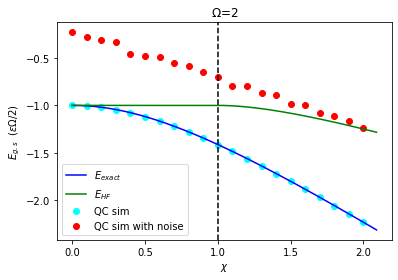

In [42]:
plt.plot(XX,np.array(exact[0]),label='$E_{exact}$',color='b')
plt.plot(XX,np.array(HF[0]),label='$E_{HF}$',color='g')
plt.scatter(chi,LM2_sim,label='QC sim',color='cyan')
plt.scatter(chi,LM2_n,label='QC sim with noise',color='r')
plt.axvline(1, color = 'k', linestyle='--')
plt.ylabel('$E_{g.s}$  $(\epsilon\Omega/2)$')
plt.xlabel('$\chi$')
plt.title(f'$\Omega$={Omega[0]}')
plt.legend()